In [1]:
## Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
## Reference frequency
omega = 106.69842

## Need to grab periods from config files
T5 = 2*np.pi/omega
T9 = 0.0830311384472535
T15 = 0.18058779627833363

## Need to grab frequencies from config file
omegas5 = [0,106.69842,-106.69842,277.4159,-277.4159]
omegas9 = [0,106.69842,-106.69842,277.4159,-277.4159,213.39684,-213.39684,170.71748,-170.71748]
omegas15 = [0, 64.01906, 106.69842, 170.71748, 213.39684, 554.8318, 277.4159, 
            384.11432, -384.11432, -277.4159, -554.8318, -213.39684, -170.71748, -106.69842, -64.09106]

In [3]:
## Get data from file
unsteady_df = pd.read_csv('2harmonic/Unsteady/history.csv').rename(columns=lambda x: x.strip())
hb5_df = pd.read_csv('2harmonic/HB/stable5h/HB_output.csv',index_col=False)
hb9_df = pd.read_csv('2harmonic/HB/stable9h/HB_output.csv',index_col=False)
hb15_df = pd.read_csv('2harmonic/HB/stable15h/HB_output.csv',index_col=False)

/tmp/ipykernel_3804972/2949054659.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  hb5_df = pd.read_csv('2harmonic/HB/stable5h/HB_output.csv',index_col=False)
/tmp/ipykernel_3804972/2949054659.py:4: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  hb9_df = pd.read_csv('2harmonic/HB/stable9h/HB_output.csv',index_col=False)
/tmp/ipykernel_3804972/2949054659.py:5: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  hb15_df = pd.read_csv('2harmonic/HB/stable15h/HB_output.csv',index_col=False)


In [4]:
## Process data
all_times = unsteady_df['"Cur_Time"'].to_numpy()*omega
all_lift = unsteady_df['"CL"'].to_numpy()

N5 = len(hb5_df['time_instance'])
hb5_times = hb5_df['time_instance'].to_numpy()*T5*omega/N5
hb5_lift = hb5_df['CL'].to_numpy()

N9 = len(hb9_df['time_instance'])
hb9_times = hb9_df['time_instance'].to_numpy()*T9*omega/N9
hb9_lift = hb9_df['CL'].to_numpy()

N15 = len(hb15_df['time_instance'])
hb15_times = hb15_df['time_instance'].to_numpy()*T15*omega/N15
hb15_lift = hb15_df['CL'].to_numpy()

In [5]:
## Define functions for Einv and interpolation

#  Einv calculation
def get_Einv(T,N,K,omegas):
    Einv = np.zeros((N,K),dtype=complex)
    for n in range(0,N):
        for k in range(0,K):
            Einv[n,k] = complex(np.cos(omegas[k]*n*T/N),np.sin(omegas[k]*n*T/N))
    return Einv

#  Interpolation
def get_interp(T,max_time,n_times,omegas,hb_lift):
    Einv = get_Einv(T,len(omegas),len(omegas),omegas)
    coeffs = np.squeeze(np.asarray(np.mat(np.linalg.inv(Einv))*np.mat(hb_lift).transpose()))
    times = np.linspace(0,max_time,num=n_times)
    interpol = np.zeros(len(times))
    for i in range(0,len(times)):
        for k in range(0,len(coeffs)):
            interpol[i] = interpol[i] + coeffs[k]*complex(np.cos(omegas[k]*times[i]),np.sin(omegas[k]*times[i]))
    return times,interpol

In [6]:
## Number of time points to interpolate
n_times = 10000

## Get interpolated values
times5,interpol5 = get_interp(T5,max(all_times)/omega,n_times,omegas5,hb5_lift)
times9,interpol9 = get_interp(T9,max(all_times)/omega,n_times,omegas9,hb9_lift)
times15,interpol15 = get_interp(T15,max(all_times)/omega,n_times,omegas15,hb15_lift)

/tmp/ipykernel_3804972/2109888424.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  interpol[i] = interpol[i] + coeffs[k]*complex(np.cos(omegas[k]*times[i]),np.sin(omegas[k]*times[i]))


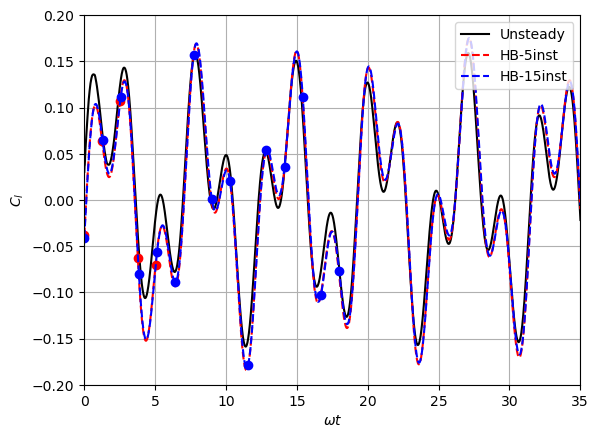

In [7]:
## Plot unsteady
plt.plot(all_times,all_lift,'-k',label='Unsteady')

## Plot for HB-5inst
plt.plot(hb5_times,hb5_lift,'or',label='_hb5')
plt.plot(times5*omega,interpol5,'--r',label='HB-5inst')

## Plot for HB-9inst
# plt.plot(hb9_times,hb9_lift,'og',label='_hb9')
# plt.plot(times9*omega,interpol9,'--g',label='HB-9inst')

## Plot for HB-15inst
plt.plot(hb15_times,hb15_lift,'ob',label='_hb15')
plt.plot(times15*omega,interpol15,'--b',label='HB-15inst')

## Beautifying the plot
plt.xlim([0, 35])
plt.ylim([-0.2, 0.2])

plt.grid()
plt.xlabel('$\omega t$');
plt.ylabel('$C_l$');
plt.legend(loc='upper right');